In [214]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

In [120]:
file_path = '../data_source/premiums.xlsx'
df = pd.read_excel(file_path)
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [159]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

### Handle NA Values

In [160]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicate values

In [161]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Handle Outliers

In [162]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [163]:
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [164]:
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356])

In [165]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

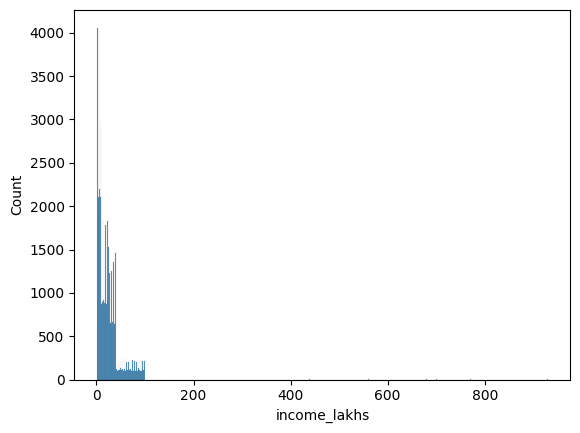

In [166]:
sns.histplot(df1.income_lakhs)

In [168]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [169]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [170]:
get_iqr_bounds(df1.income_lakhs)

(-29.0, 67.0)

In [171]:
quantile_threshold = df1.income_lakhs.quantile(.999)

In [172]:
df1[df1.income_lakhs > quantile_threshold].shape

(10, 13)

In [173]:
df2 = df1[df1.income_lakhs < quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49808.000000,49808.000000,49808.000000,49808.000000
mean,34.399333,1.717214,22.735083,15756.332276
std,13.683206,1.492056,21.921788,8417.581174
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8602.000000
50%,31.000000,2.000000,16.000000,13919.000000
75%,45.000000,3.000000,31.000000,22263.250000
max,72.000000,5.000000,99.000000,43471.000000


In [174]:
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

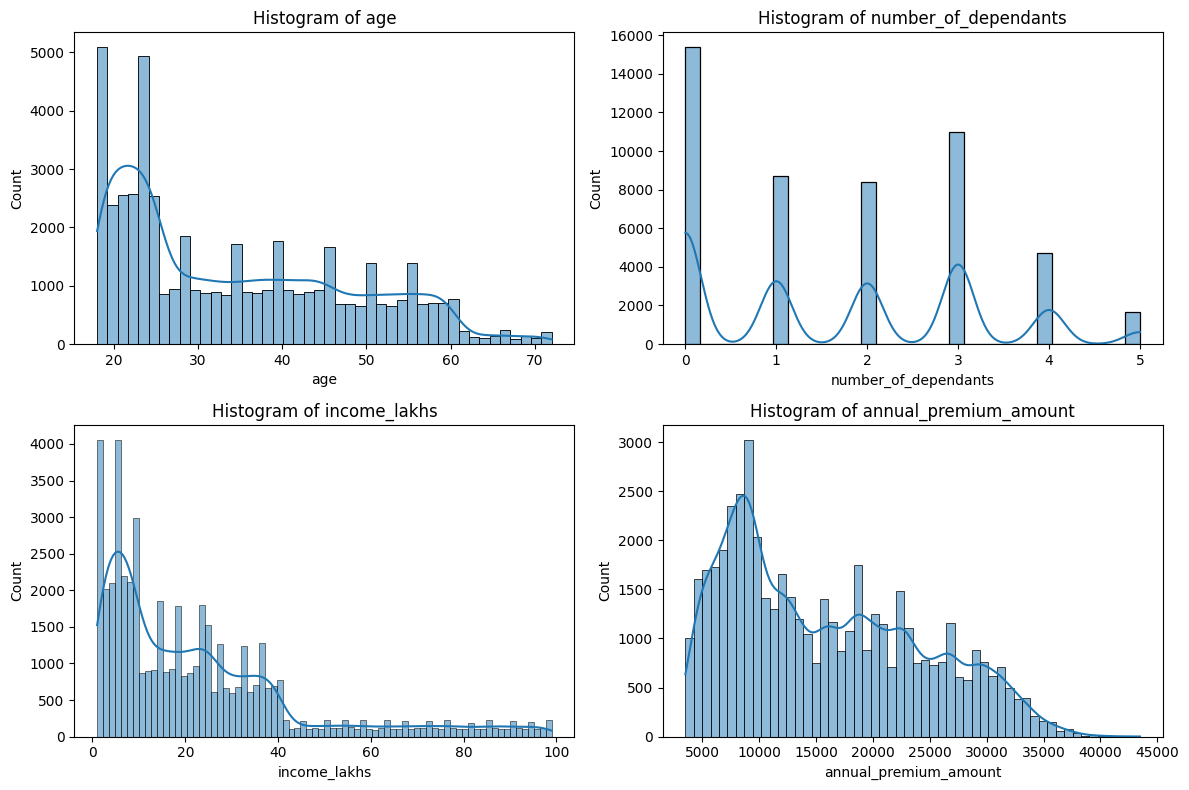

In [175]:
numeric_columns = df2.select_dtypes(include=['int', 'float']).columns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

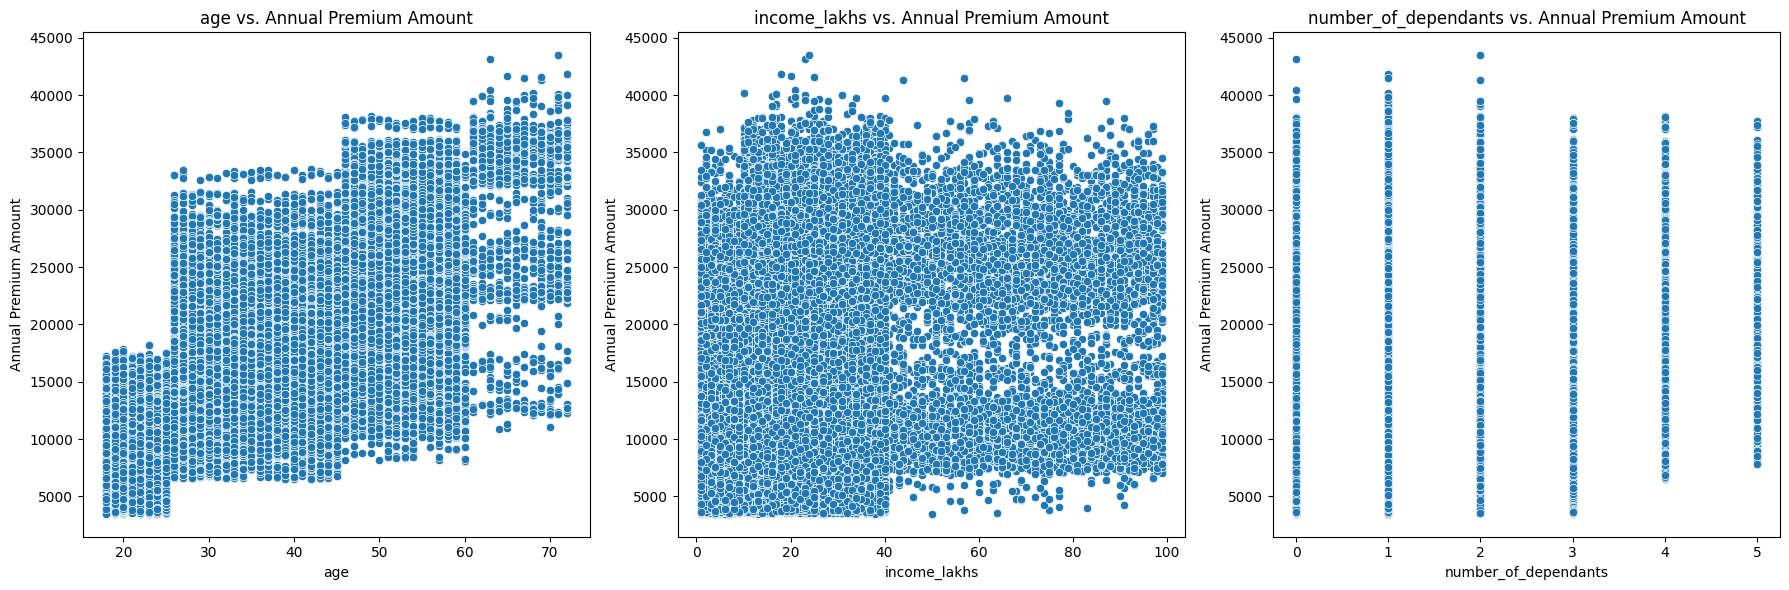

In [176]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [177]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [178]:
for col in categorical_cols:
    print(col, ":" ,df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [179]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace = True)

df2['smoking_status'].unique()


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

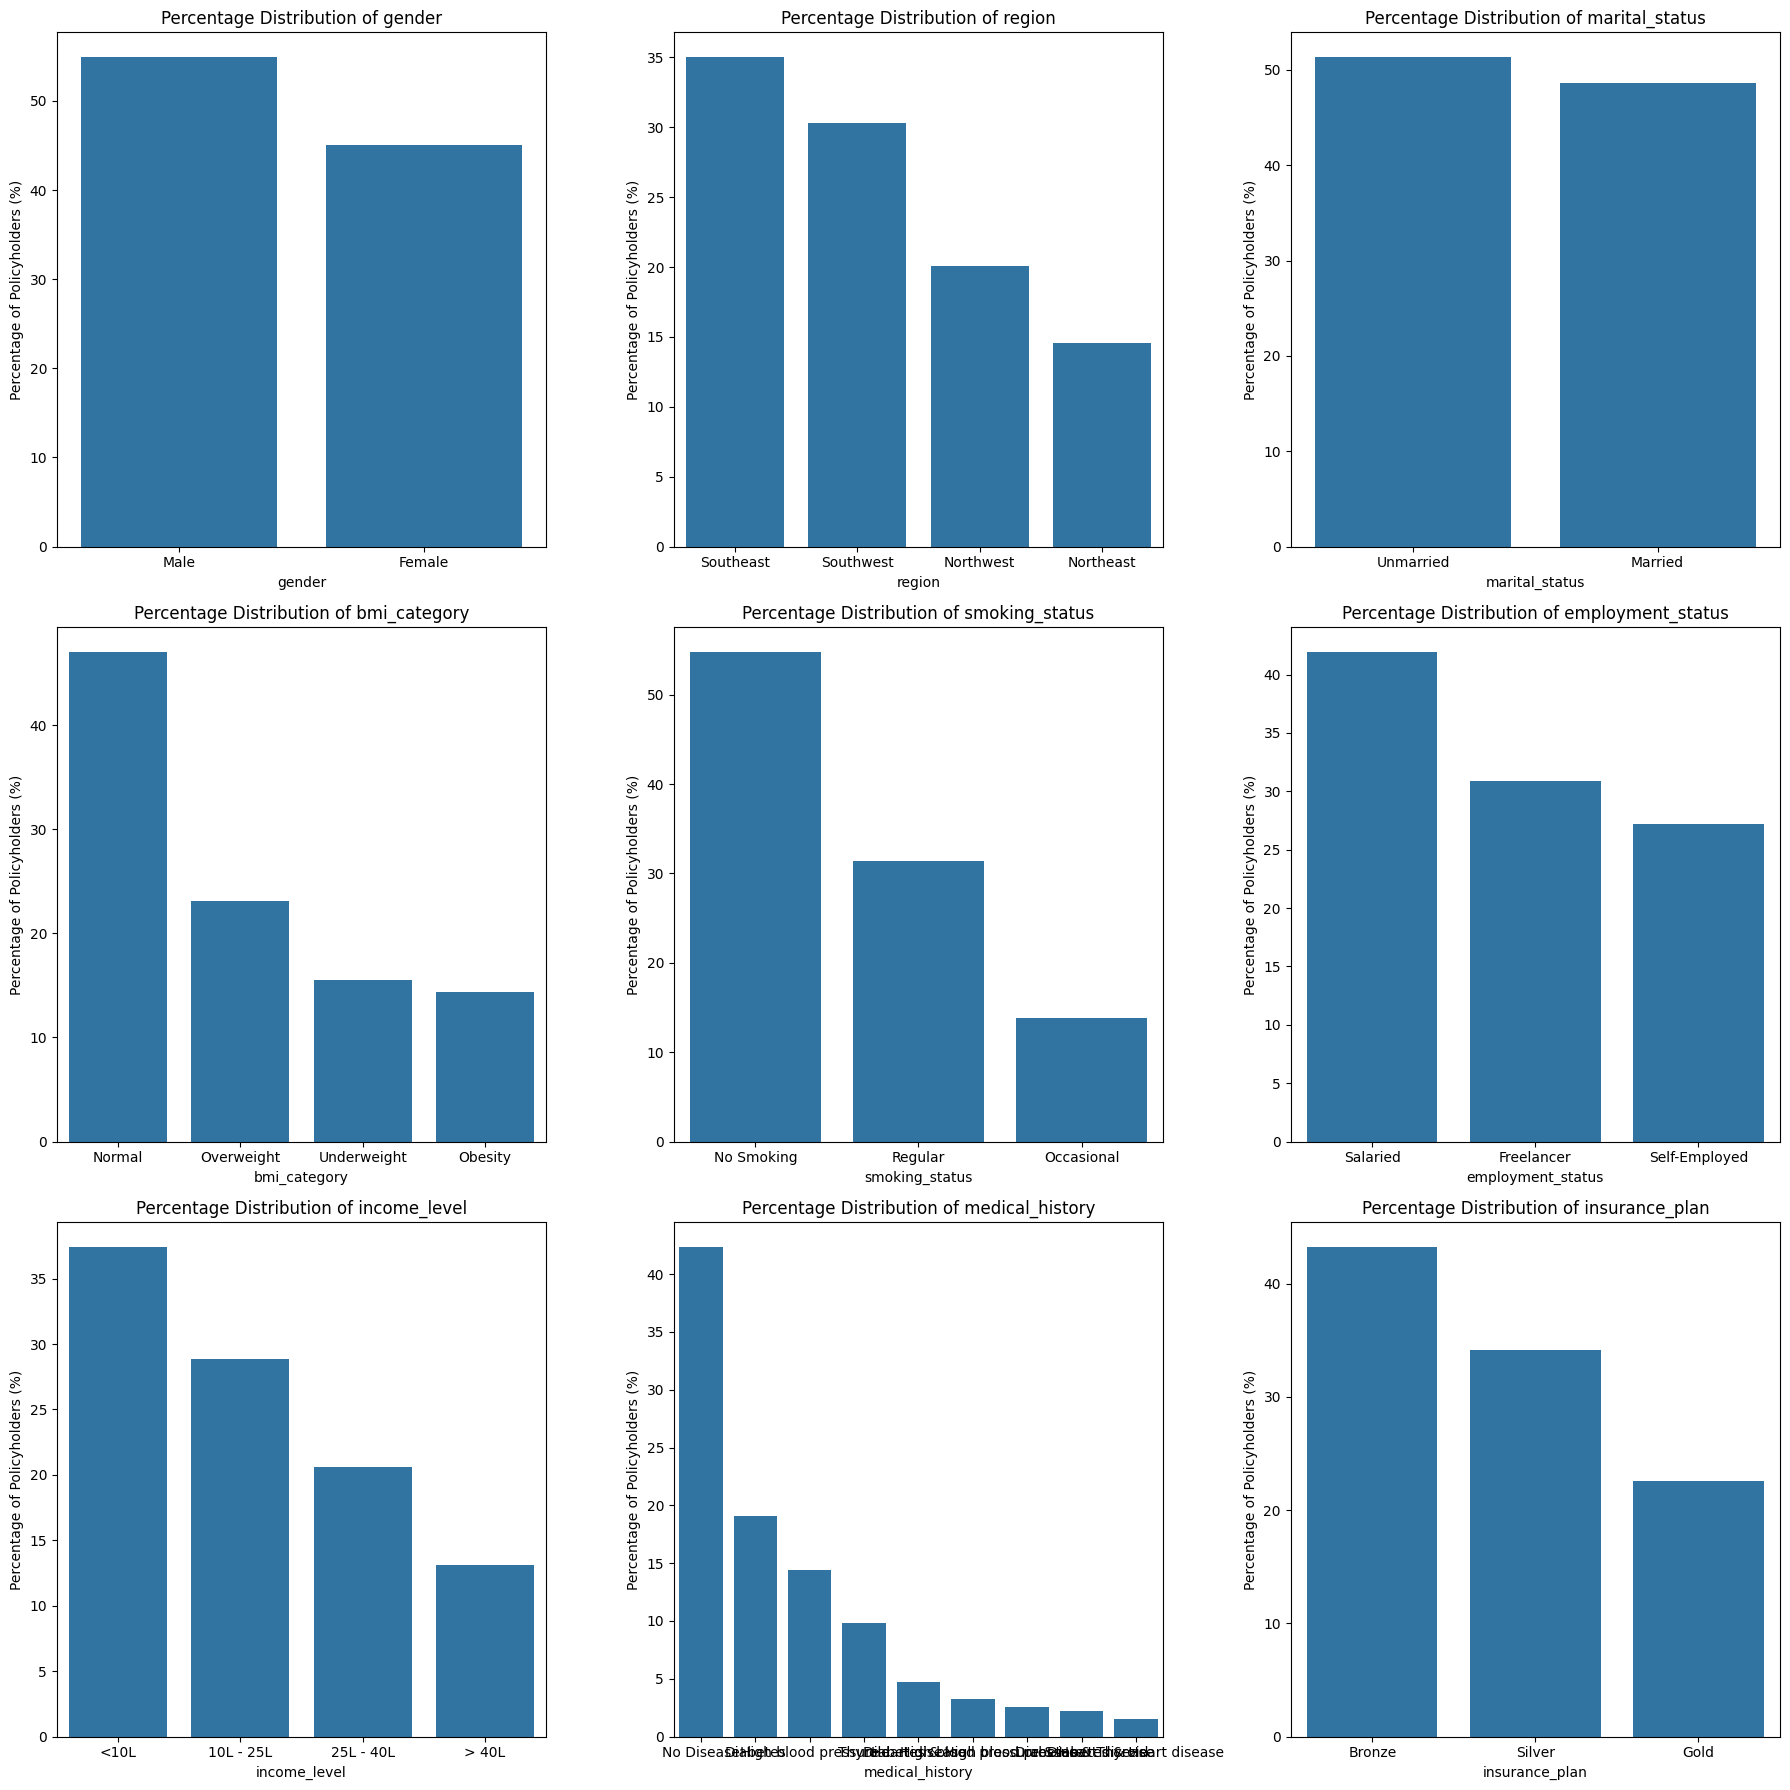

In [180]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()  

for ax, column in zip(axes, categorical_cols):
    category_counts = df2[column].value_counts(normalize=True) * 100  

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column) 

plt.tight_layout() 
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              326  3593    2604


<Axes: xlabel='income_level'>

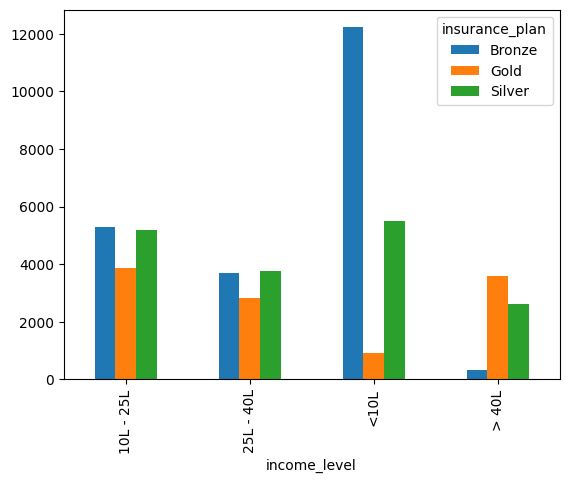

In [181]:
cross_stab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(cross_stab)

cross_stab.plot(kind = "bar")

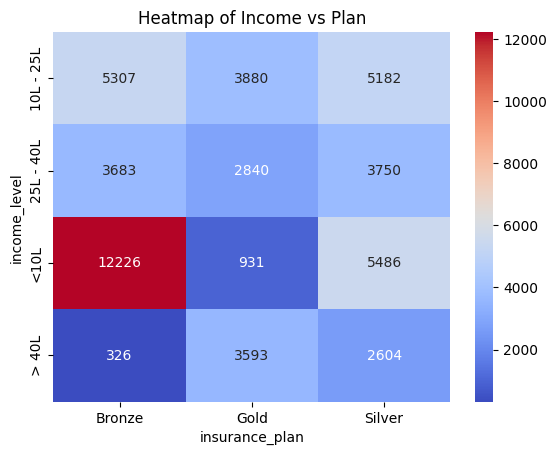

In [182]:
sns.heatmap(cross_stab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

## Feature Engineering

In [183]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [184]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())


In [185]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)

df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571


In [186]:
df2.head(2)


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


In [187]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [188]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze' : 1,
    'Silver' : 2,
    'Gold'   : 3
})

In [189]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571


In [190]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [191]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [192]:
df2['income_level'].unique()

array([1, 2, 4, 3])

In [193]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [194]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


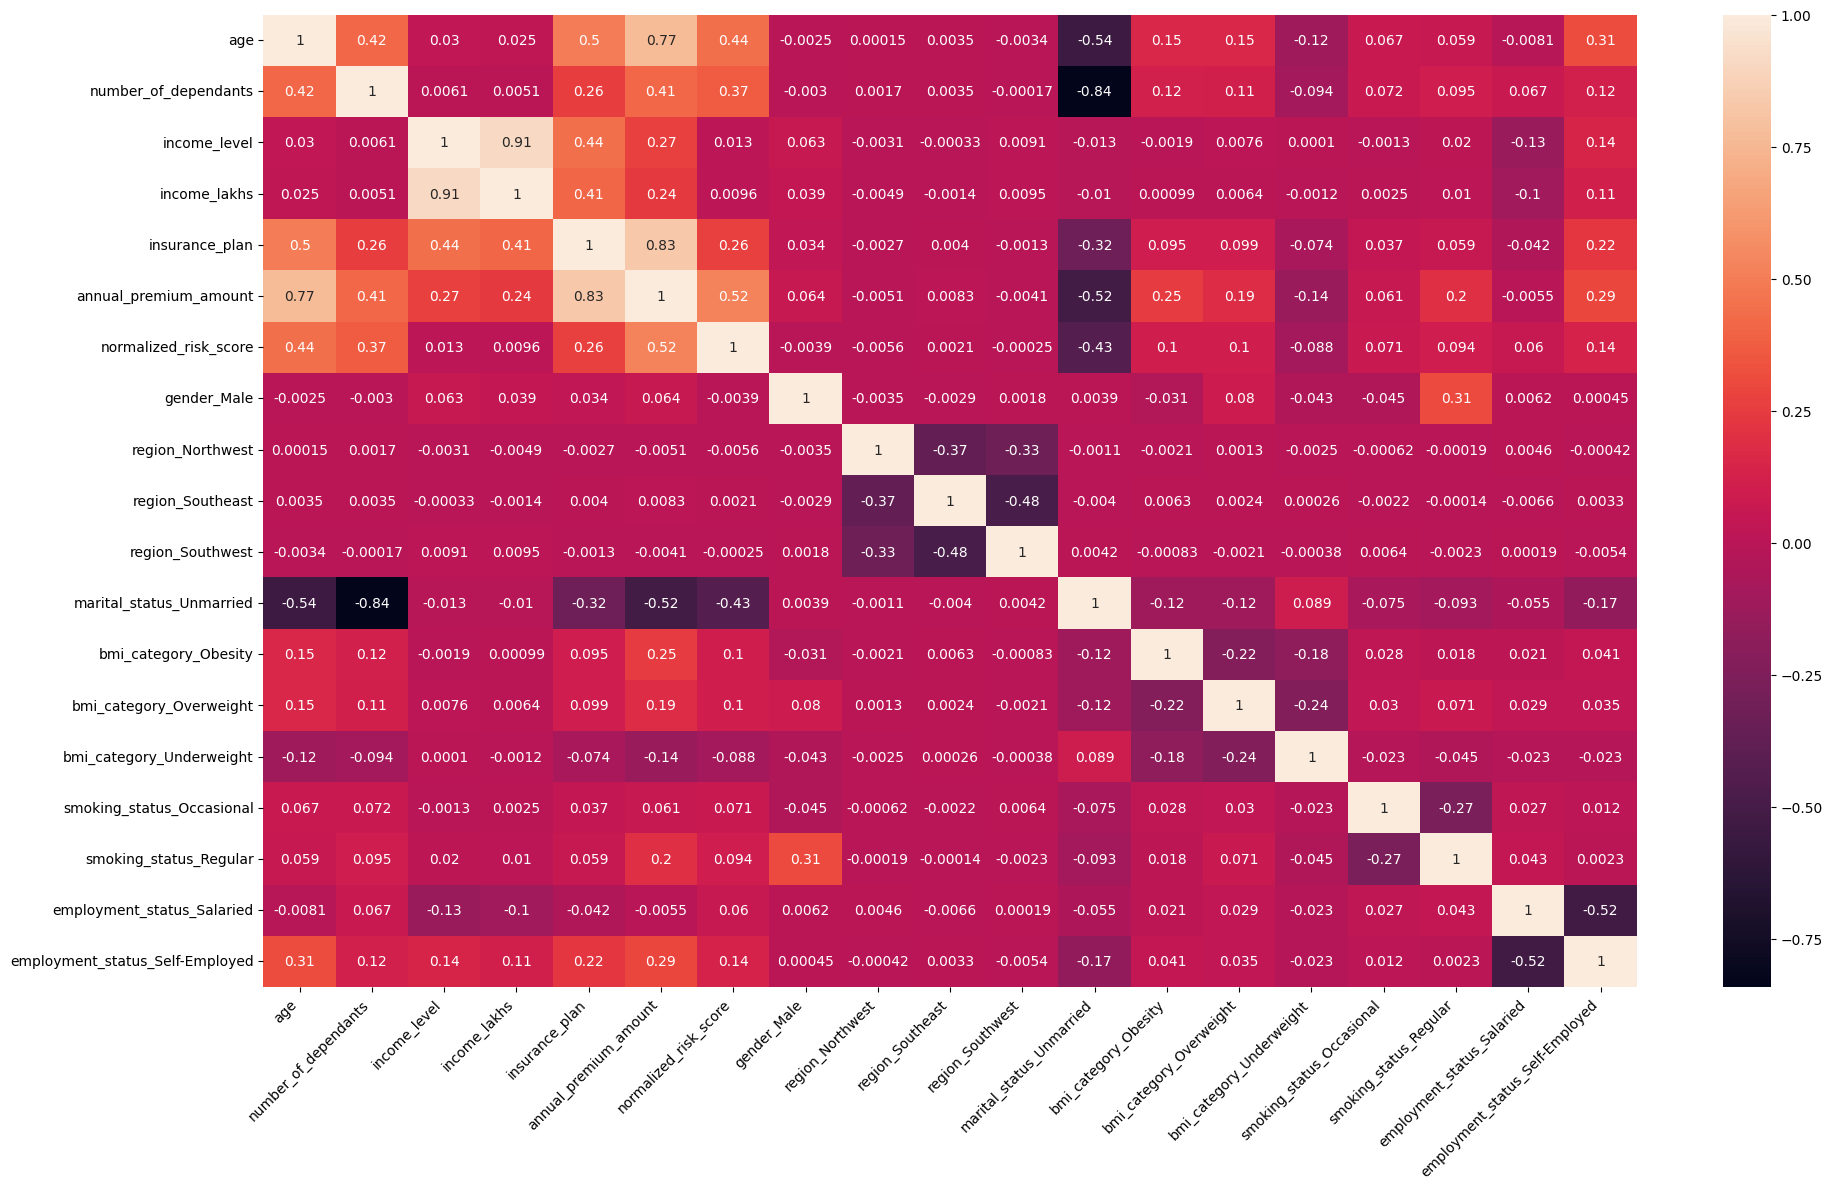

In [195]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [196]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000,49808.000000
mean,0.303691,0.343443,0.364627,0.221787,0.396623,0.291816,0.549530,0.200972,0.350365,0.302963,0.513693,0.143250,0.231148,0.155276,0.138291,0.313765,0.419471,0.272004
std,0.253393,0.298411,0.348905,0.223692,0.392273,0.287456,0.497546,0.400731,0.477089,0.459544,0.499817,0.350331,0.421571,0.362171,0.345209,0.464027,0.493477,0.444997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.153061,0.500000,0.357143,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.306122,0.500000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [199]:
calculate_vif(X)

,Column,VIF
0,age,4.568203
1,number_of_dependants,4.533619
2,income_level,12.609918
3,income_lakhs,11.390919
4,insurance_plan,3.574805
5,normalized_risk_score,2.686553
6,gender_Male,2.420908
7,region_Northwest,2.101878
8,region_Southeast,2.921178
9,region_Southwest,2.669438


In [200]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,4.546399
1,number_of_dependants,4.526213
2,income_lakhs,2.487302
3,insurance_plan,3.438176
4,normalized_risk_score,2.686293
5,gender_Male,2.409383
6,region_Northwest,2.100181
7,region_Southeast,2.918617
8,region_Southwest,2.667140
9,marital_status_Unmarried,3.396399


In [201]:
X_reduced = X.drop('income_level', axis="columns")

## Model Training

### Linear Regression Model

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3, random_state=10)

In [204]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

print(f"train score : {train_score}, test_score : {test_score}")

train score : 0.9282872866388545, test_score : 0.9277068802881225


In [205]:
model_lr.intercept_

4721.284227923561

In [206]:
model_lr.coef_

array([11320.84480976,  -598.60654635,  -387.23104353, 12445.21223389,
        4830.35511008,   141.16467047,   -19.93312597,    72.90102336,
          18.96701435,  -880.43219853,  3363.77237148,  1616.18488467,
         359.97028802,   679.17891348,  2239.27098107,   165.26365654,
         414.73816833])

In [207]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [209]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending = True)
coef_df

,Coefficients
marital_status_Unmarried,-880.432199
number_of_dependants,-598.606546
income_lakhs,-387.231044
region_Northwest,-19.933126
region_Southwest,18.967014
region_Southeast,72.901023
gender_Male,141.164670
employment_status_Salaried,165.263657
bmi_category_Underweight,359.970288
employment_status_Self-Employed,414.738168


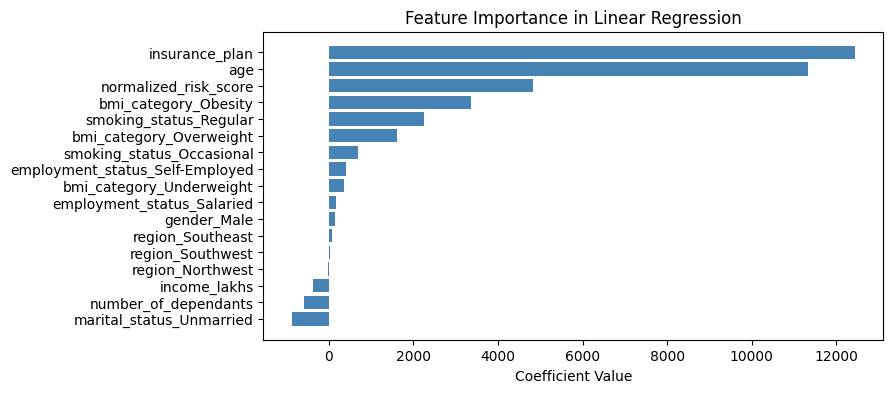

In [210]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [211]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282872483442924, 0.9277070896912124)

In [212]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  5134548.568564918 RMSE:  2265.9542291416474


### XGBoost Model

In [217]:
model_xgb = XGBRegressor()

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9812403432070997

In [216]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1585213.8423258385 RMSE:  1259.052755974045


### XGBoost Model Finetuning

In [218]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9809418370344957

In [221]:
random_search.best_params_

In [223]:
best_model = random_search.best_estimator_

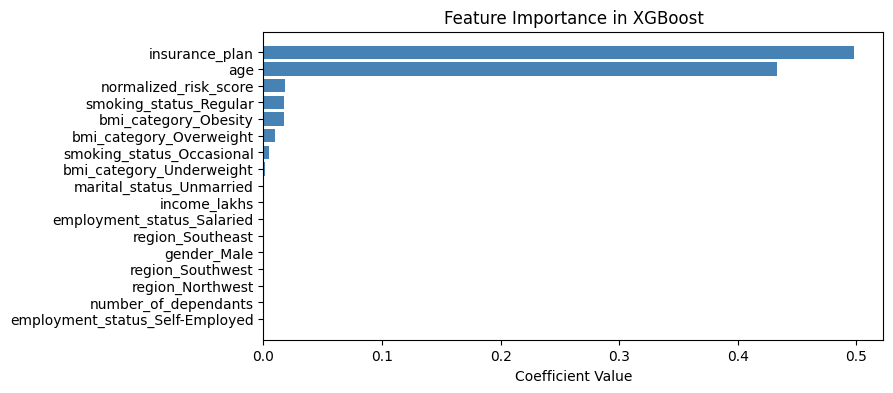

In [224]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending = True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [227]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
34025,6539,6582.131836,43.131836,0.659609
29504,11853,14702.767578,2849.767578,24.042585
12892,31155,30673.974609,-481.025391,-1.543975
34662,4395,6674.643555,2279.643555,51.869023
25334,19986,19694.580078,-291.419922,-1.458120


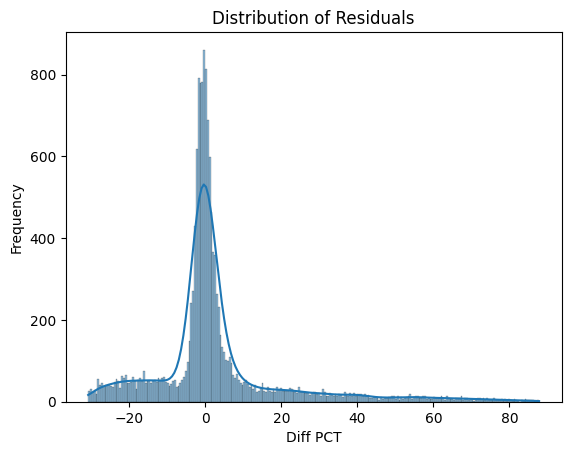

In [228]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [231]:
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4460, 4)

In [234]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.846750987084253

In [235]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
624,3505,6582.131836,3077.131836,87.792634
7461,3503,6573.801758,3070.801758,87.662054
49360,3512,6581.906738,3069.906738,87.411923
10288,3517,6590.236816,3073.236816,87.382338
1692,3522,6590.236816,3068.236816,87.116321
...,...,...,...,...
27900,4739,7118.727051,2379.727051,50.215806
33079,4591,6894.110840,2303.110840,50.165777
17787,4987,7487.787109,2500.787109,50.146122
44112,4461,6696.688477,2235.688477,50.116307


In [236]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
29504,0.092593,0.6,0.040816,1.0,0.428571,0,0,0,1,0,0,0,0,0,0,1,0
34662,0.000000,0.6,0.102041,0.0,0.000000,1,0,0,1,0,0,0,1,0,0,0,0


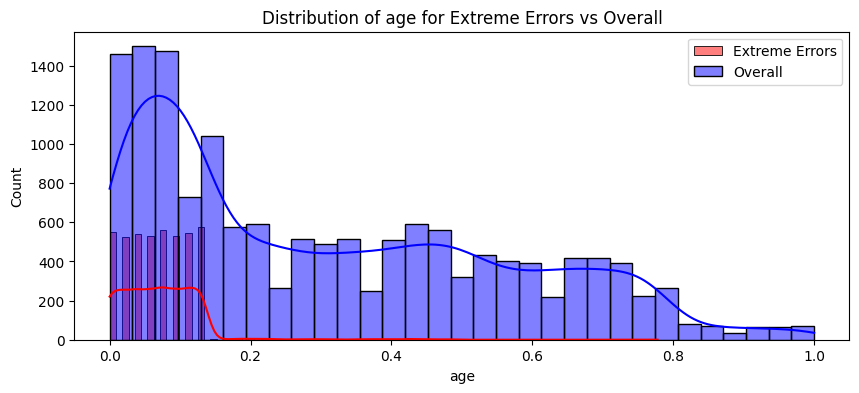

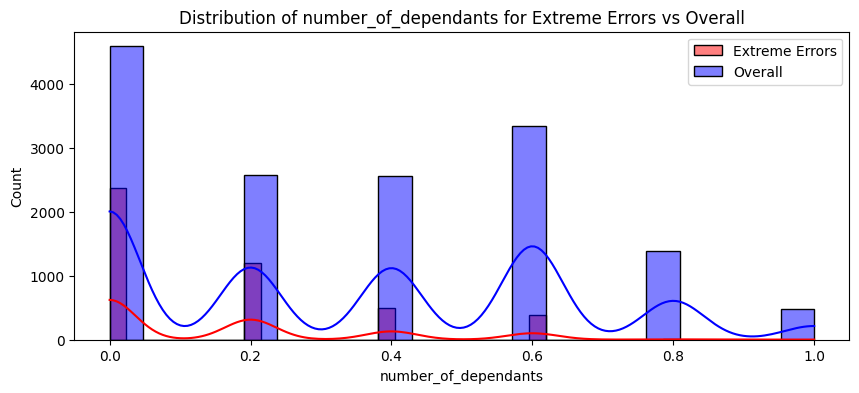

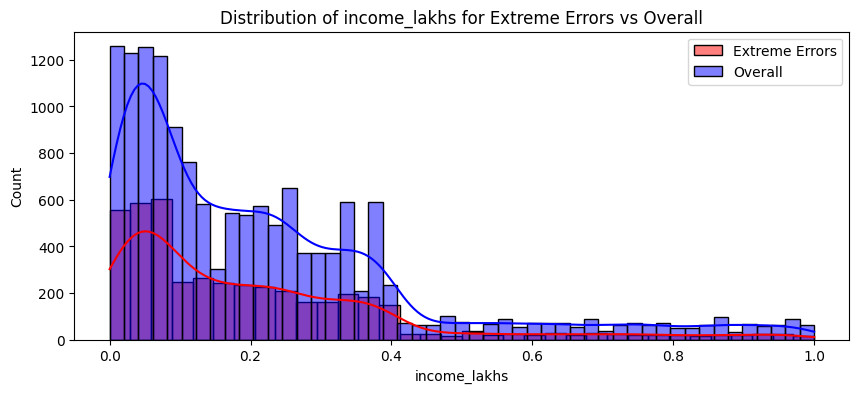

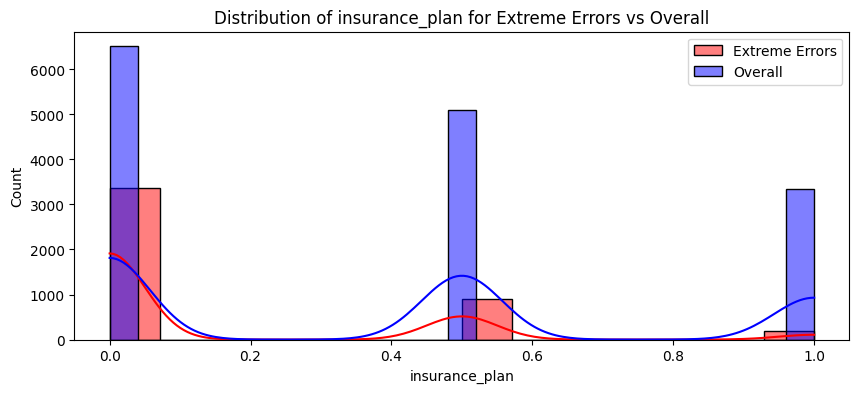

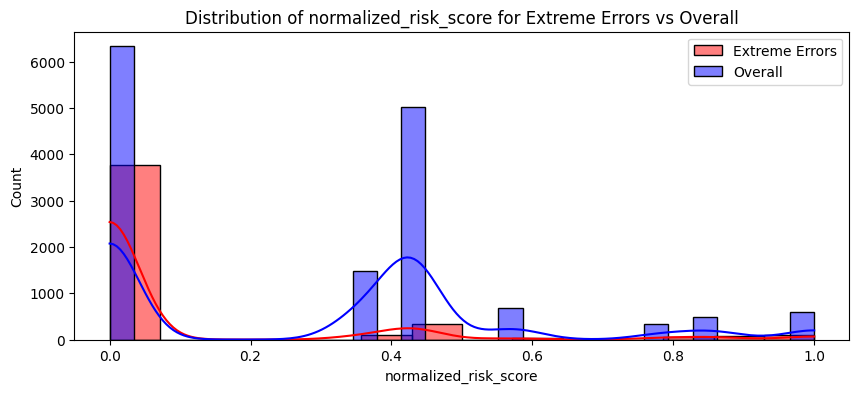

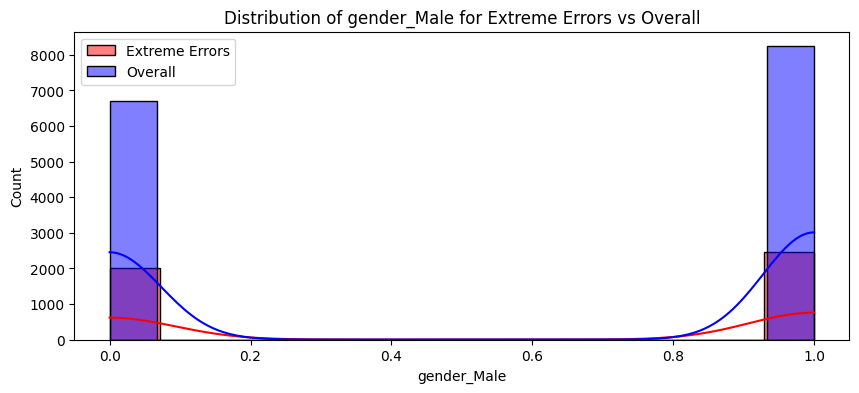

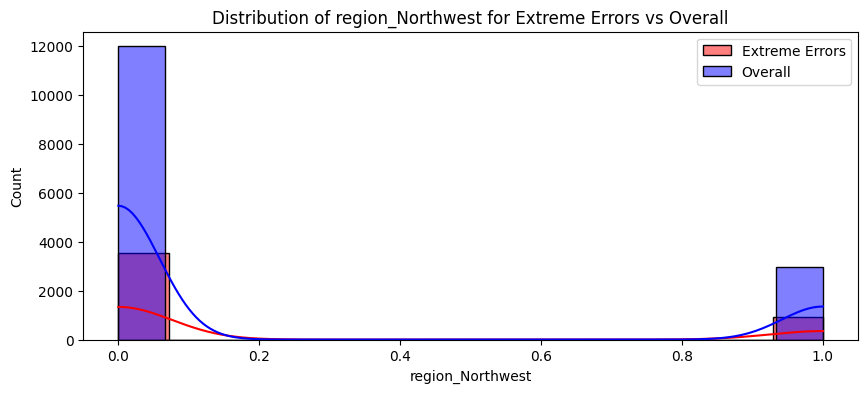

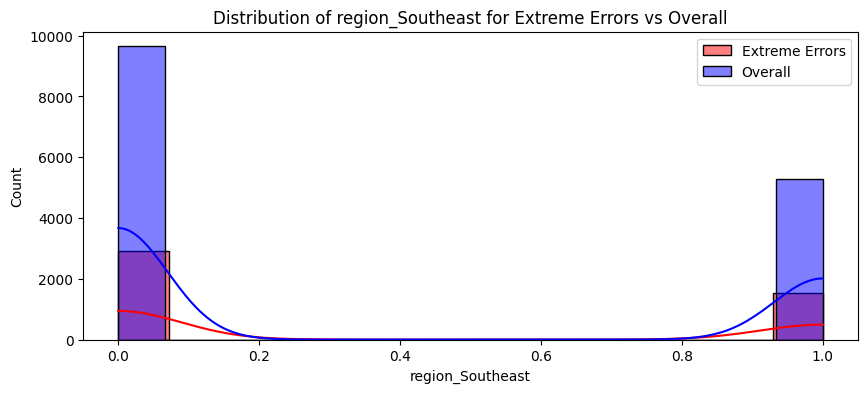

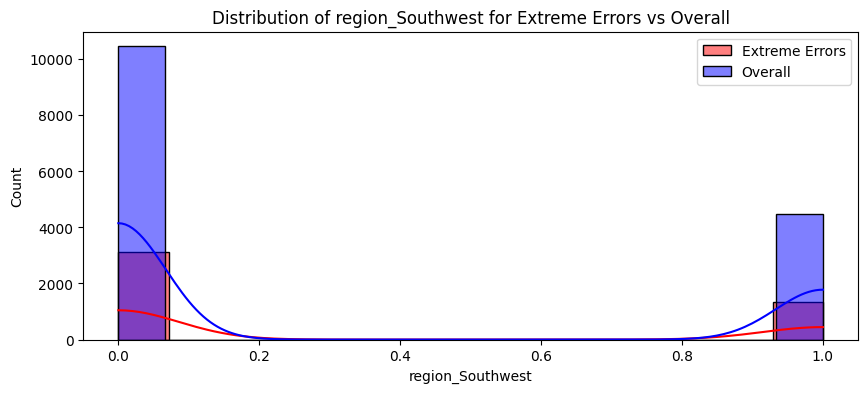

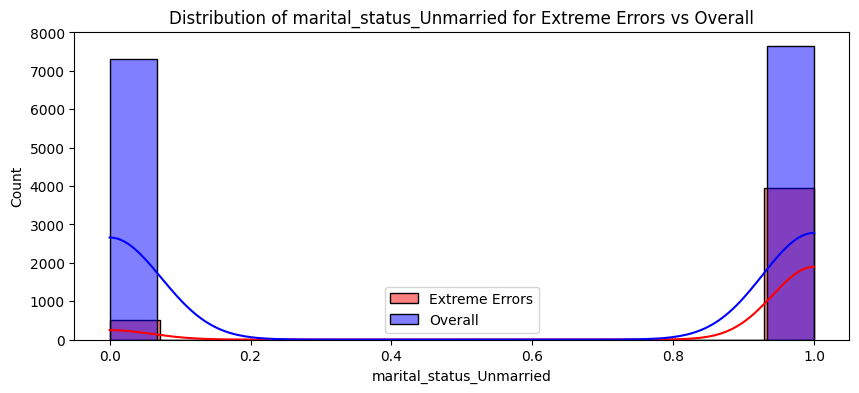

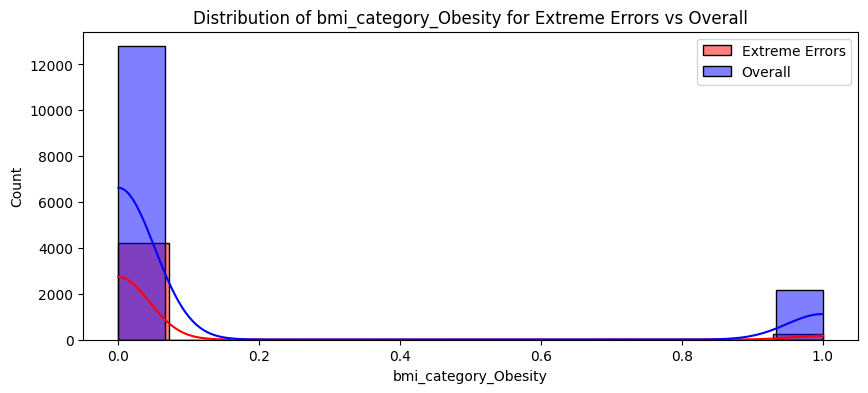

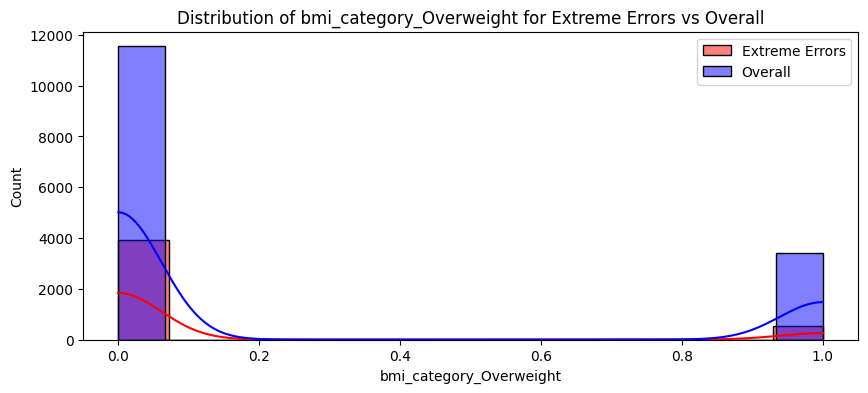

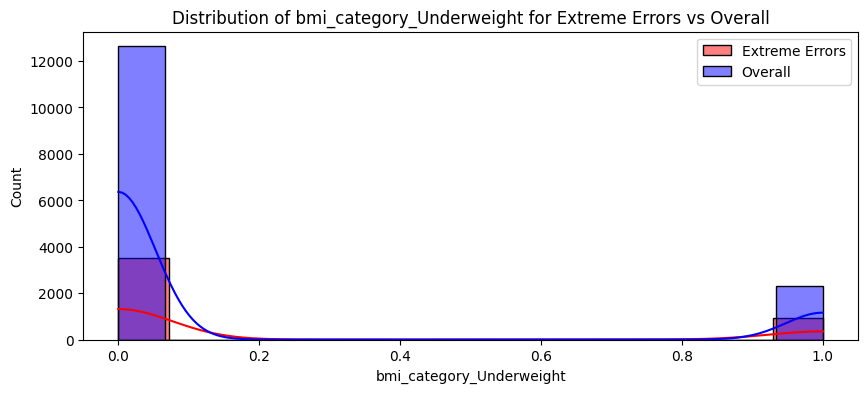

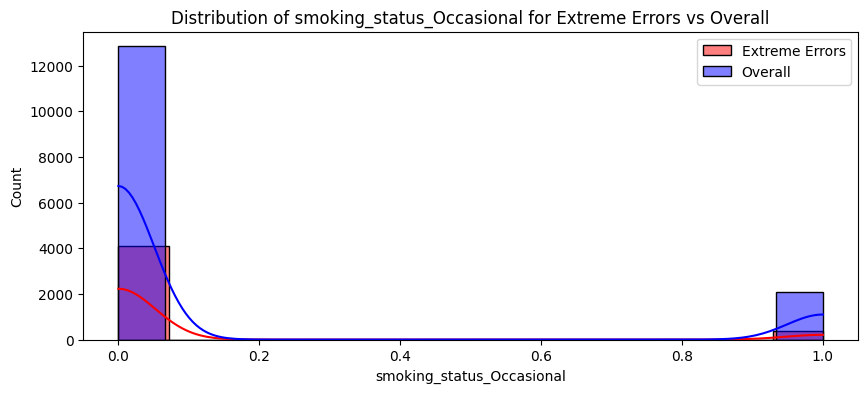

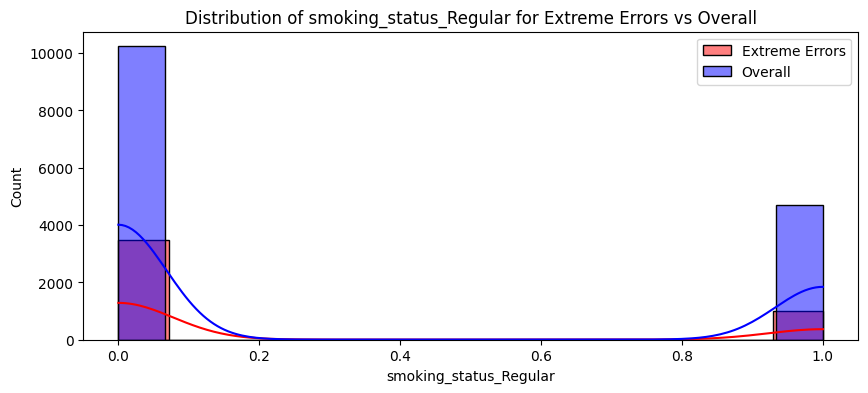

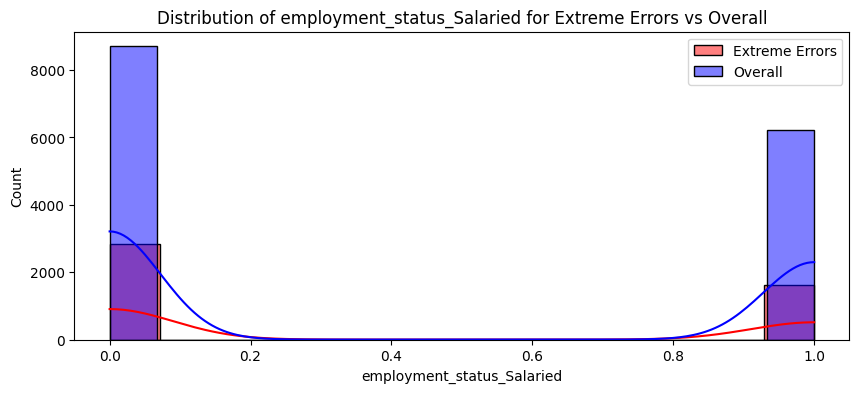

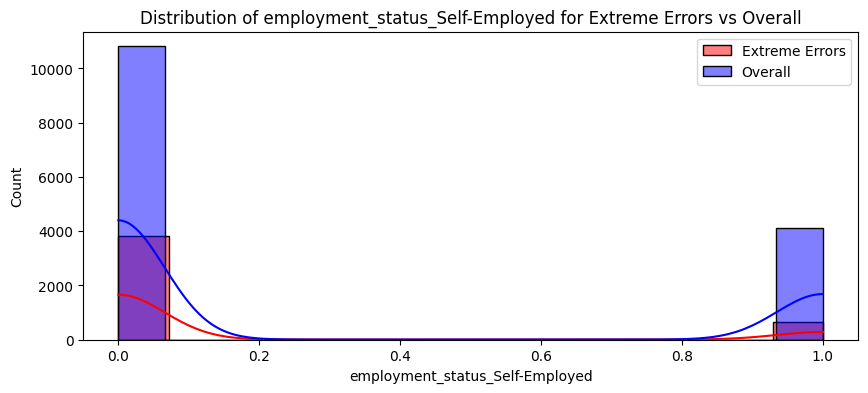

In [237]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### Reverse Sacaling

In [238]:
extreme_errors_df['income_level']=-1

In [239]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,3.0,-2.0,5.0,3.0
1,18.0,3.0,-2.0,11.0,1.0
2,20.0,0.0,-2.0,34.0,1.0
3,25.0,0.0,-2.0,37.0,1.0
4,23.0,0.0,-2.0,63.0,2.0


In [240]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4460.000000,4460.000000,4460.0,4460.000000,4460.000000
mean,21.841256,0.756726,-2.0,21.082735,1.287892
std,3.170904,0.977322,0.0,20.179484,0.538357
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,99.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

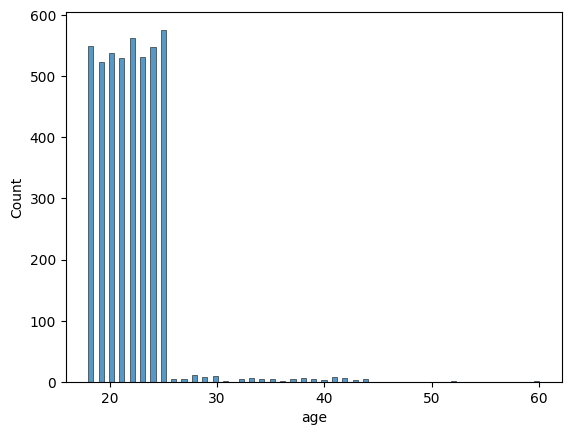

In [241]:
sns.histplot(df_reversed.age)